# Подержанные автомобили

Датасет содержит информацию о характеристиках и ценах подержанных автомобилей в некоторой стране

## Импорт библиотек, константы

In [1]:
pip install --upgrade pandas

In [2]:
pip install catboost

In [3]:
pip install lightgbm

In [4]:
pip install --upgrade pandas "dask[complete]"

In [5]:
pip install -U scikit-learn

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score


RANDOM_STATE = 12345

### Загрузка

In [7]:
df = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_from_idea_to_mvp/main/datasets/cars.csv")
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0


### Описание данных

**Целевая переменная**
- `selling_price`: цена продажи, числовая

**Признаки**
- `name` (string): модель автомобиля
- `year` (numeric, int): год выпуска с завода-изготовителя
- `km_driven` (numeric, int): пробег на дату продажи
- `fuel` (categorical: _Diesel_ или _Petrol_, или _CNG_, или _LPG_, или _electric_): тип топлива
- `seller_type` (categorical: _Individual_ или _Dealer_, или _Trustmark Dealer_): продавец
- `transmission` (categorical: _Manual_ или _Automatic_): тип трансмиссии
- `owner` (categorical: _First Owner_ или _Second Owner_, или _Third Owner_, или _Fourth & Above Owner_): какой по счёту хозяин?
- `mileage` (string, по смыслу числовой): пробег, требует предобработки
- `engine` (string, по смыслу числовой): рабочий объем двигателя, требует предобработки
- `max_power` (string, по смыслу числовой): пиковая мощность двигателя, требует предобработки
- `torque` (string, по смыслу числовой, а то и 2): крутящий момент, требует предобработки
- `seats` (numeric, float; по смыслу categorical, int)

In [8]:
# информация от столбцах
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6999 non-null   object 
 1   year           6999 non-null   int64  
 2   selling_price  6999 non-null   int64  
 3   km_driven      6999 non-null   int64  
 4   fuel           6999 non-null   object 
 5   seller_type    6999 non-null   object 
 6   transmission   6999 non-null   object 
 7   owner          6999 non-null   object 
 8   mileage        6797 non-null   object 
 9   engine         6797 non-null   object 
 10  max_power      6803 non-null   object 
 11  torque         6796 non-null   object 
 12  seats          6797 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 711.0+ KB


In [9]:
df.shape

(6999, 13)

In [10]:
df = df.drop_duplicates()

In [11]:
df.shape

(6014, 13)

In [12]:
df.isna().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          190
engine           190
max_power        187
torque           191
seats            190
dtype: int64

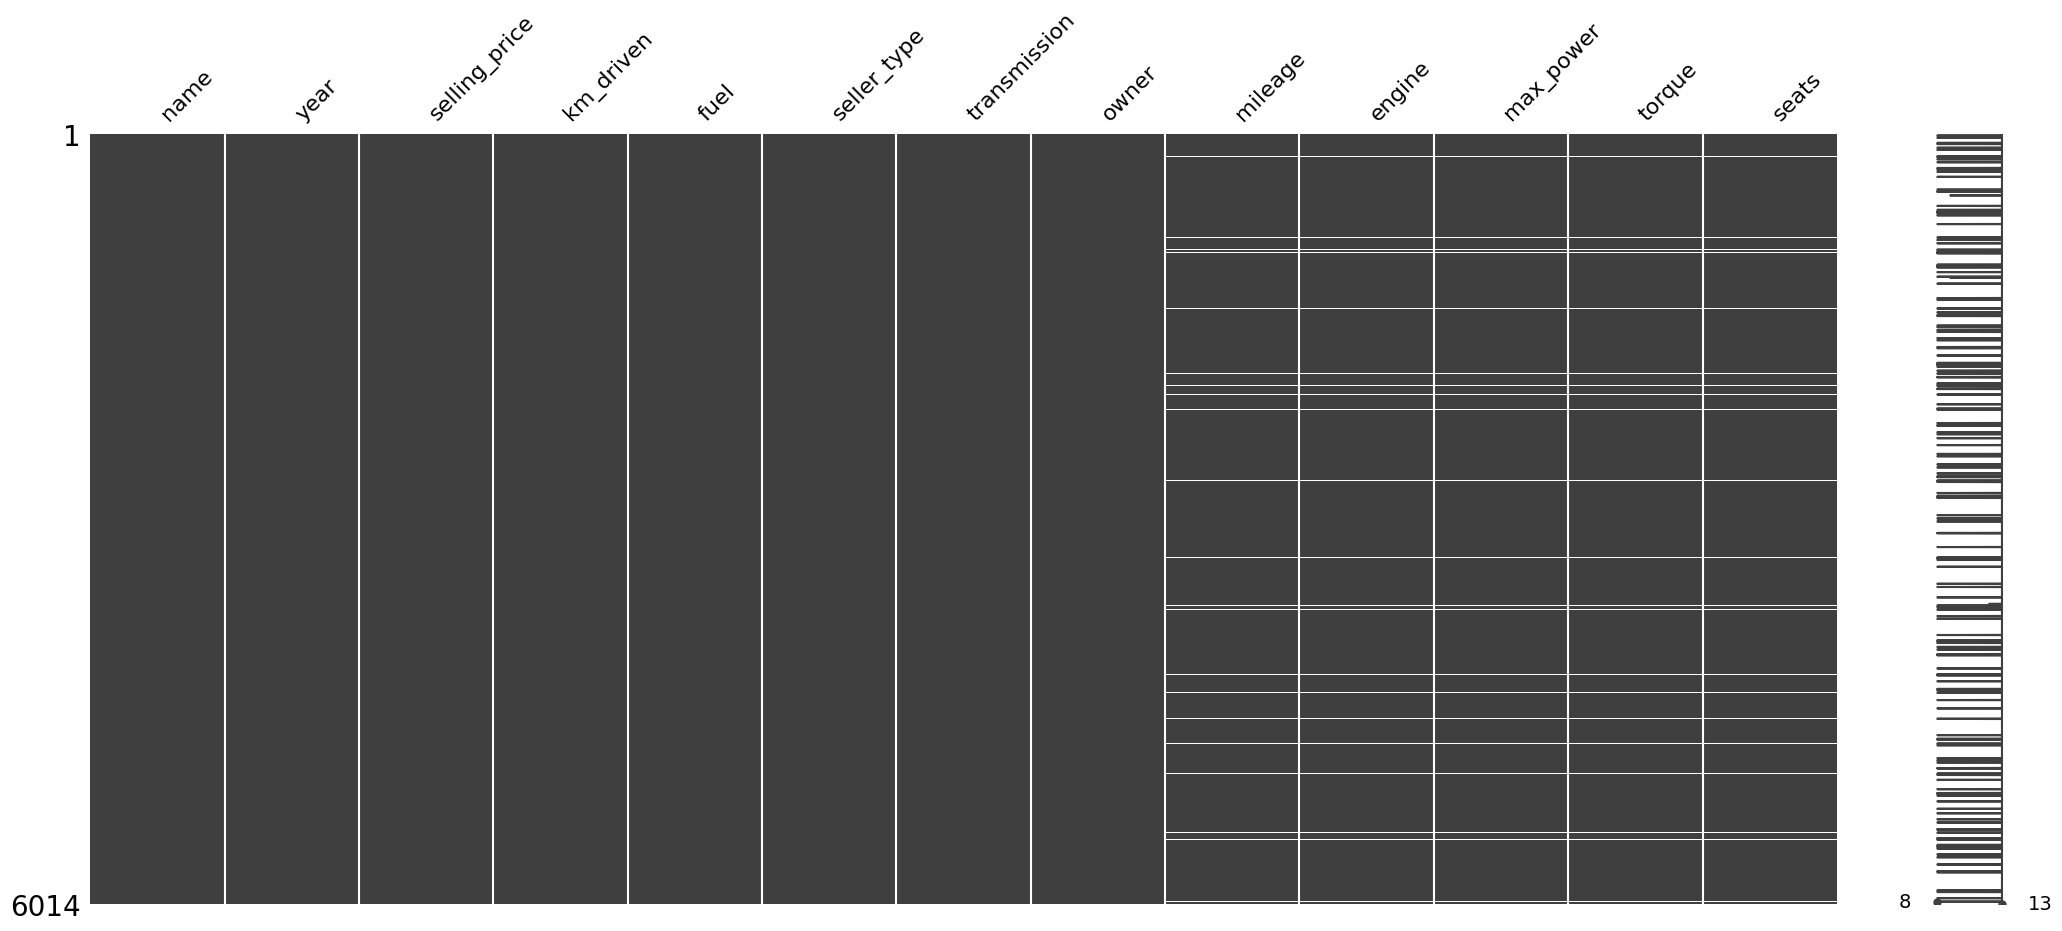

In [13]:
import missingno as msg
msg.matrix(df);

Пропуски имеются в пяти столбцах - mileage, engine, max_power, torque, seats. При этом проруски в одних и тех же строках, поэтому не будем их никаким образом заполнять, а просто удалим.

In [14]:
df.dropna(ignore_index=True, inplace=True)

In [15]:
df.isna().sum()

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
mileage          0
engine           0
max_power        0
torque           0
seats            0
dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5823 entries, 0 to 5822
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           5823 non-null   object 
 1   year           5823 non-null   int64  
 2   selling_price  5823 non-null   int64  
 3   km_driven      5823 non-null   int64  
 4   fuel           5823 non-null   object 
 5   seller_type    5823 non-null   object 
 6   transmission   5823 non-null   object 
 7   owner          5823 non-null   object 
 8   mileage        5823 non-null   object 
 9   engine         5823 non-null   object 
 10  max_power      5823 non-null   object 
 11  torque         5823 non-null   object 
 12  seats          5823 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 591.5+ KB


In [17]:
df[['mileage','mileage_unit']] = df['mileage'].str.split(" ", expand=True)
df[['engine','engine_unit']] = df['engine'].str.split(" ", expand=True)
df[['max_power','max_power_unit']] = df['max_power'].str.split(" ", expand=True)
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,mileage_unit,engine_unit,max_power_unit
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4,1248,74,190Nm@ 2000rpm,5.0,kmpl,CC,bhp
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250Nm@ 1500-2500rpm,5.0,kmpl,CC,bhp
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0,1396,90,22.4 kgm at 1750-2750rpm,5.0,kmpl,CC,bhp
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1,1298,88.2,"11.5@ 4,500(kgm@ rpm)",5.0,kmpl,CC,bhp
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197,81.86,113.75nm@ 4000rpm,5.0,kmpl,CC,bhp


In [18]:
df_unit = ['mileage_unit', 'engine_unit', 'max_power_unit']
for s in df_unit:
  print(df[s].value_counts())
  print('----------------------------')

mileage_unit
kmpl     5746
km/kg      77
Name: count, dtype: int64
----------------------------
engine_unit
CC    5823
Name: count, dtype: int64
----------------------------
max_power_unit
bhp    5823
Name: count, dtype: int64
----------------------------


In [19]:
df[['mileage', 'engine', 'max_power']] = df[['mileage', 'engine', 'max_power']].astype(float)

Mileage has 2 different units, if possible should convert km/kg to kmpl.

In [20]:
df.loc[df['mileage_unit']=='km/kg','mileage'] = df.loc[df['mileage_unit']=='km/kg','mileage'] * 1.5

In [21]:
df.drop(['mileage_unit', 'engine_unit', 'max_power_unit'], axis= 1 , inplace= True )

In [22]:
df[['name', 'fuel','seller_type', 'transmission', 'owner', 'torque']] = df[['name', 'fuel','seller_type', 'transmission', 'owner', 'torque']].apply(lambda s: s.str.lower())

In [23]:
df['name'] = df['name'].str.replace('land rover', 'land-rover')

In [24]:
df['name'].value_counts()

name
maruti swift dzire vdi                          135
maruti alto lxi                                  68
maruti alto 800 lxi                              65
maruti swift dzire vxi                           50
maruti swift vdi                                 50
                                               ... 
hyundai getz 1.1 gvs                              1
maruti 800 ex bsii                                1
datsun go t option                                1
mahindra scorpio 2.6 sportz crde                  1
toyota innova 2.5 gx (diesel) 8 seater bs iv      1
Name: count, Length: 1837, dtype: int64

In [25]:
df[['brand', 'model', '2', '3', '4', '5', '6', '7', '8', '9']] = df['name'].str.split(" ", expand=True)

In [26]:
df

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,...,brand,model,2,3,4,5,6,7,8,9
0,maruti swift dzire vdi,2014,450000,145500,diesel,individual,manual,first owner,23.40,1248.0,...,maruti,swift,dzire,vdi,None,None,None,None,None,None
1,skoda rapid 1.5 tdi ambition,2014,370000,120000,diesel,individual,manual,second owner,21.14,1498.0,...,skoda,rapid,1.5,tdi,ambition,None,None,None,None,None
2,hyundai i20 sportz diesel,2010,225000,127000,diesel,individual,manual,first owner,23.00,1396.0,...,hyundai,i20,sportz,diesel,None,None,None,None,None,None
3,maruti swift vxi bsiii,2007,130000,120000,petrol,individual,manual,first owner,16.10,1298.0,...,maruti,swift,vxi,bsiii,None,None,None,None,None,None
4,hyundai xcent 1.2 vtvt e plus,2017,440000,45000,petrol,individual,manual,first owner,20.14,1197.0,...,hyundai,xcent,1.2,vtvt,e,plus,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5818,hyundai santro xing gls,2008,120000,191000,petrol,individual,manual,first owner,17.92,1086.0,...,hyundai,santro,xing,gls,None,None,None,None,None,None
5819,maruti wagon r vxi bs iv with abs,2013,260000,50000,petrol,individual,manual,second owner,18.90,998.0,...,maruti,wagon,r,vxi,bs,iv,with,abs,None,None
5820,hyundai i20 magna,2013,320000,110000,petrol,individual,manual,first owner,18.50,1197.0,...,hyundai,i20,magna,None,None,None,None,None,None,None
5821,hyundai verna crdi sx,2007,135000,119000,diesel,individual,manual,fourth & above owner,16.80,1493.0,...,hyundai,verna,crdi,sx,None,None,None,None,None,None


In [27]:
df.fillna('', inplace=True)

In [28]:
df['variant'] = df[['2', '3', '4', '5', '6', '7', '8', '9']].agg(' '.join, axis=1)

In [29]:
df['brand'] = df[['brand', 'model']].agg(' '.join, axis=1)

In [30]:
df

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,...,model,2,3,4,5,6,7,8,9,variant
0,maruti swift dzire vdi,2014,450000,145500,diesel,individual,manual,first owner,23.40,1248.0,...,swift,dzire,vdi,,,,,,,dzire vdi
1,skoda rapid 1.5 tdi ambition,2014,370000,120000,diesel,individual,manual,second owner,21.14,1498.0,...,rapid,1.5,tdi,ambition,,,,,,1.5 tdi ambition
2,hyundai i20 sportz diesel,2010,225000,127000,diesel,individual,manual,first owner,23.00,1396.0,...,i20,sportz,diesel,,,,,,,sportz diesel
3,maruti swift vxi bsiii,2007,130000,120000,petrol,individual,manual,first owner,16.10,1298.0,...,swift,vxi,bsiii,,,,,,,vxi bsiii
4,hyundai xcent 1.2 vtvt e plus,2017,440000,45000,petrol,individual,manual,first owner,20.14,1197.0,...,xcent,1.2,vtvt,e,plus,,,,,1.2 vtvt e plus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5818,hyundai santro xing gls,2008,120000,191000,petrol,individual,manual,first owner,17.92,1086.0,...,santro,xing,gls,,,,,,,xing gls
5819,maruti wagon r vxi bs iv with abs,2013,260000,50000,petrol,individual,manual,second owner,18.90,998.0,...,wagon,r,vxi,bs,iv,with,abs,,,r vxi bs iv with abs
5820,hyundai i20 magna,2013,320000,110000,petrol,individual,manual,first owner,18.50,1197.0,...,i20,magna,,,,,,,,magna
5821,hyundai verna crdi sx,2007,135000,119000,diesel,individual,manual,fourth & above owner,16.80,1493.0,...,verna,crdi,sx,,,,,,,crdi sx


In [31]:
df['torque'].loc[df['torque'].str.contains('rpm') == False]

123                400nm
337                400nm
1270      510@ 1600-2400
2597       135.4nm@ 2500
3103       135.4nm@ 2500
3159    190nm@ 2000-3000
3167          210 / 1900
4034          210 / 1900
4177          210 / 1900
4633          210 / 1900
4814       135.4nm@ 2500
5160          210 / 1900
5276          210 / 1900
5447          210 / 1900
5680               400nm
Name: torque, dtype: object

In [32]:
df.loc[df['torque'] == '400nm']

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,...,model,2,3,4,5,6,7,8,9,variant
123,volvo xc40 d4 r-design,2018,3400000,22000,diesel,dealer,automatic,first owner,18.0,1969.0,...,xc40,d4,r-design,,,,,,,d4 r-design
337,volvo xc40 d4 inscription bsiv,2019,3800000,20000,diesel,individual,automatic,first owner,18.0,1969.0,...,xc40,d4,inscription,bsiv,,,,,,d4 inscription bsiv
5680,volvo s90 d4 inscription bsiv,2019,5500000,17000,diesel,individual,automatic,first owner,18.0,1969.0,...,s90,d4,inscription,bsiv,,,,,,d4 inscription bsiv


In [33]:
df['torque'].unique()

array(['190nm@ 2000rpm', '250nm@ 1500-2500rpm',
       '22.4 kgm at 1750-2750rpm', '11.5@ 4,500(kgm@ rpm)',
       '113.75nm@ 4000rpm', '7.8@ 4,500(kgm@ rpm)', '59nm@ 2500rpm',
       '170nm@ 1800-2400rpm', '160nm@ 2000rpm', '248nm@ 2250rpm',
       '78nm@ 4500rpm', '84nm@ 3500rpm', '115nm@ 3500-3600rpm',
       '62nm@ 3000rpm', '219.7nm@ 1500-2750rpm', '200nm@ 1750rpm',
       '115nm@ 4000rpm', '69nm@ 3500rpm', '172.5nm@ 1750rpm',
       '6.1kgm@ 3000rpm', '60nm@ 3500rpm', '90nm@ 3500rpm',
       '151nm@ 4850rpm', '104nm@ 4000rpm', '320nm@ 1700-2700rpm',
       '250nm@ 1750-2500rpm', '145nm@ 4600rpm', '146nm@ 4800rpm',
       '343nm@ 1400-3400rpm', '200nm@ 1400-3400rpm',
       '200nm@ 1250-4000rpm', '400nm@ 2000-2500rpm',
       '360nm@ 1200-3400rpm', '200nm@ 1200-3600rpm',
       '380nm@ 1750-2500rpm', '400nm@ 1750-3000rpm',
       '400nm@ 1400-2800rpm', '200nm@ 1750-3000rpm', '111.7nm@ 4000rpm',
       '219.6nm@ 1500-2750rpm', '112nm@ 4000rpm', '250nm@ 1500-3000rpm',
       '130nm@

In [34]:
df['torque'] = df['torque'].str.replace('(', '').str.replace(')', '').str.replace(',', '').str.replace(' ', '')

In [35]:
df['torque'].unique()

array(['190nm@2000rpm', '250nm@1500-2500rpm', '22.4kgmat1750-2750rpm',
       '11.5@4500kgm@rpm', '113.75nm@4000rpm', '7.8@4500kgm@rpm',
       '59nm@2500rpm', '170nm@1800-2400rpm', '160nm@2000rpm',
       '248nm@2250rpm', '78nm@4500rpm', '84nm@3500rpm',
       '115nm@3500-3600rpm', '62nm@3000rpm', '219.7nm@1500-2750rpm',
       '200nm@1750rpm', '115nm@4000rpm', '69nm@3500rpm',
       '172.5nm@1750rpm', '6.1kgm@3000rpm', '60nm@3500rpm',
       '90nm@3500rpm', '151nm@4850rpm', '104nm@4000rpm',
       '320nm@1700-2700rpm', '250nm@1750-2500rpm', '145nm@4600rpm',
       '146nm@4800rpm', '343nm@1400-3400rpm', '200nm@1400-3400rpm',
       '200nm@1250-4000rpm', '400nm@2000-2500rpm', '360nm@1200-3400rpm',
       '200nm@1200-3600rpm', '380nm@1750-2500rpm', '400nm@1750-3000rpm',
       '400nm@1400-2800rpm', '200nm@1750-3000rpm', '111.7nm@4000rpm',
       '219.6nm@1500-2750rpm', '112nm@4000rpm', '250nm@1500-3000rpm',
       '130nm@4000rpm', '205nm@1750-3250rpm', '280nm@1350-4600rpm',
       '99.0

In [36]:
df[['torque_nm','torque_max_rpm', 'torque_del1', 'torque_del2']] = df['torque'].str.split("@|at|/", expand=True)

In [37]:
df['torque_del1'].unique()

array([None, 'rpm', '-500rpm', '-500nm'], dtype=object)

In [38]:
df['torque_del2'].unique()

array([None, 'rpm'], dtype=object)

In [39]:
df['torque_nm'].unique()

array(['190nm', '250nm', '22.4kgm', '11.5', '113.75nm', '7.8', '59nm',
       '170nm', '160nm', '248nm', '78nm', '84nm', '115nm', '62nm',
       '219.7nm', '200nm', '69nm', '172.5nm', '6.1kgm', '60nm', '90nm',
       '151nm', '104nm', '320nm', '145nm', '146nm', '343nm', '400nm',
       '360nm', '380nm', '111.7nm', '219.6nm', '112nm', '130nm', '205nm',
       '280nm', '99.04nm', '77nm', '110nm', '153nm', '113.7nm', '114nm',
       '113nm', '290nm', '120nm', '135nm', '259.8nm', '173nm', '259.9nm',
       '91nm', '96.1nm', '109nm', '202nm', '430nm', '382nm', '620nm',
       '250', '500nm', '550nm', '490nm', '177.5nm', '300nm', '260nm',
       '213nm', '224nm', '640nm', '114.7nm', '95nm', '13.1kgm', '71nm',
       '11.4kgm', '140nm', '134nm', '150nm', '340nm', '240nm', '72nm',
       '330nm', '101nm', '12.5', '111.8nm', '11.8', '135.4nm', '190.25nm',
       '117nm', '20.4', '247nm', '180nm', '195nm', '154.9nm', '114.73nm',
       '108nm', '190.24nm', '420nm', '100nm', '51nm', '132nm', '350

In [40]:
df['torque_max_rpm'].value_counts

<bound method IndexOpsMixin.value_counts of 0            2000rpm
1       1500-2500rpm
2       1750-2750rpm
3            4500kgm
4            4000rpm
            ...     
5818         3000rpm
5819         3500rpm
5820         4000rpm
5821    1900-2750kgm
5822         2000rpm
Name: torque_max_rpm, Length: 5823, dtype: object>

In [41]:
df['torque_nm'] = df['torque_nm'].replace(to_replace=('nm','kgm'), value= '',  regex=True).astype(float)

In [42]:
df['torque_nm'].values[610] = 38.7

In [43]:
df['torque_nm'].value_counts()

torque_nm
200.0    517
190.0    483
90.0     304
114.0    196
113.0    154
        ... 
155.0      1
72.9       1
128.0      1
131.0      1
436.4      1
Name: count, Length: 235, dtype: int64

In [44]:
df['torque_nm'].loc[df['torque'].str.contains('kgm')] = df['torque_nm'].loc[df['torque'].str.contains('kgm')] * 10

<ipython-input-44-59897b90421b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['torque_nm'].loc[df['torque'].str.contains('kgm')] = df['torque_nm'].loc[df['torque'].str.contains('kgm')] * 10


In [45]:
df['torque_nm'].sort_values(ascending=False)

3900    1900.0
891     1450.0
4069    1450.0
3146    1450.0
1770    1450.0
         ...  
4111      51.0
5487      51.0
4733      51.0
4255      48.0
4853      48.0
Name: torque_nm, Length: 5823, dtype: float64

In [46]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,...,5,6,7,8,9,variant,torque_nm,torque_max_rpm,torque_del1,torque_del2
0,maruti swift dzire vdi,2014,450000,145500,diesel,individual,manual,first owner,23.40,1248.0,...,,,,,,dzire vdi,190.00,2000rpm,None,None
1,skoda rapid 1.5 tdi ambition,2014,370000,120000,diesel,individual,manual,second owner,21.14,1498.0,...,,,,,,1.5 tdi ambition,250.00,1500-2500rpm,None,None
2,hyundai i20 sportz diesel,2010,225000,127000,diesel,individual,manual,first owner,23.00,1396.0,...,,,,,,sportz diesel,224.00,1750-2750rpm,None,None
3,maruti swift vxi bsiii,2007,130000,120000,petrol,individual,manual,first owner,16.10,1298.0,...,,,,,,vxi bsiii,115.00,4500kgm,rpm,None
4,hyundai xcent 1.2 vtvt e plus,2017,440000,45000,petrol,individual,manual,first owner,20.14,1197.0,...,plus,,,,,1.2 vtvt e plus,113.75,4000rpm,None,None


In [47]:
df['torque_del1'].unique()

array([None, 'rpm', '-500rpm', '-500nm'], dtype=object)

In [48]:
df['torque_max_rpm'].unique()

array(['2000rpm', '1500-2500rpm', '1750-2750rpm', '4500kgm', '4000rpm',
       '2500rpm', '1800-2400rpm', '2250rpm', '4500rpm', '3500rpm',
       '3500-3600rpm', '3000rpm', '1500-2750rpm', '1750rpm', '4850rpm',
       '1700-2700rpm', '1750-2500rpm', '4600rpm', '4800rpm',
       '1400-3400rpm', '1250-4000rpm', '2000-2500rpm', '1200-3400rpm',
       '1200-3600rpm', '1750-3000rpm', '1400-2800rpm', '1500-3000rpm',
       '1750-3250rpm', '1350-4600rpm', '3750rpm', '3800rpm', '4200rpm',
       '1800-2800rpm', '4250rpm', '1500~4500rpm', '1750-2800rpm',
       '1900-2750rpm', '1900rpm', '3600-5200rpm', '1750-2250rpm',
       '1600-2400rpm', '1250-5000rpm', '1600-1800rpm', '1600-3600rpm',
       None, '1600rpm', '2750rpm', '1750-4000rpm', '4700rpm',
       '1200-4000rpm', '1200-1400rpm', '1740rpm', '3000-4300rpm',
       '3200rpm', '1500-4000rpm', '1800-3250rpm', '1600-2800rpm',
       '4386rpm', '3500kgm', '3200kgm', '1800-3000rpm', '1400-3400kgm',
       '1800-2000rpm', '1440-1500rpm', '1400-

In [49]:
df['torque_max_rpm'] = df['torque_max_rpm'].str.replace('(', '').str.replace(')', '').str.replace('kgm', '').str.replace('rpm', '')

In [50]:
df['torque_max_rpm'] = df['torque_max_rpm'].str[-5:]


In [51]:
df['torque_max_rpm'].unique()

array(['2000', '-2500', '-2750', '4500', '4000', '2500', '-2400', '2250',
       '3500', '-3600', '3000', '1750', '4850', '-2700', '4600', '4800',
       '-3400', '-4000', '-3000', '-2800', '-3250', '-4600', '3750',
       '3800', '4200', '4250', '~4500', '1900', '-5200', '-2250', '-5000',
       '-1800', None, '1600', '2750', '4700', '-1400', '1740', '-4300',
       '3200', '4386', '-2000', '-1500', '-2200', '4400', '-2600', '2700',
       '-5300', '-3200', '4300', '5000', '1800', '3600', '4388', '2600',
       '4100', '4000+', '4750', '3300', '3100', '3400', '-3800', '1850',
       '1500', '2650', '-4500', '-4100', '-4700', '-3500', '2200', '2400',
       '21800', '3000+', '2800'], dtype=object)

In [52]:
df['torque_max_rpm'] = df['torque_max_rpm'].str.replace('-', '').str.replace('~', '').str.replace('+', '')

In [53]:
df['torque_max_rpm'].value_counts()

torque_max_rpm
4000     757
2000     686
3500     592
3000     513
2500     466
1750     444
2750     358
2800     324
4200     197
4500     185
2200     143
3400     139
2700      90
2250      87
4800      76
1500      66
4250      62
4386      60
4400      56
3250      56
2400      52
4600      51
3600      48
1900      46
2600      44
1800      38
4300      30
4100      25
5000      22
3750      20
3200      19
4850      19
3800      15
4700       8
4750       7
3100       6
3300       3
1400       2
1850       1
2650       1
5200       1
4388       1
5300       1
1740       1
1600       1
21800      1
Name: count, dtype: int64

In [54]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,...,5,6,7,8,9,variant,torque_nm,torque_max_rpm,torque_del1,torque_del2
0,maruti swift dzire vdi,2014,450000,145500,diesel,individual,manual,first owner,23.40,1248.0,...,,,,,,dzire vdi,190.00,2000,None,None
1,skoda rapid 1.5 tdi ambition,2014,370000,120000,diesel,individual,manual,second owner,21.14,1498.0,...,,,,,,1.5 tdi ambition,250.00,2500,None,None
2,hyundai i20 sportz diesel,2010,225000,127000,diesel,individual,manual,first owner,23.00,1396.0,...,,,,,,sportz diesel,224.00,2750,None,None
3,maruti swift vxi bsiii,2007,130000,120000,petrol,individual,manual,first owner,16.10,1298.0,...,,,,,,vxi bsiii,115.00,4500,rpm,None
4,hyundai xcent 1.2 vtvt e plus,2017,440000,45000,petrol,individual,manual,first owner,20.14,1197.0,...,plus,,,,,1.2 vtvt e plus,113.75,4000,None,None


In [55]:
df.drop(['name', '2', '3', '4', '5', '6', '7', '8', '9','torque', 'torque_del1','torque_del2'], axis= 1 , inplace= True )

In [56]:
df = df.dropna(axis = 0, how ='any')

In [57]:
df = df.reset_index(drop = True)

In [58]:
df['torque_max_rpm'] = df['torque_max_rpm'].astype(int)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5820 entries, 0 to 5819
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            5820 non-null   int64  
 1   selling_price   5820 non-null   int64  
 2   km_driven       5820 non-null   int64  
 3   fuel            5820 non-null   object 
 4   seller_type     5820 non-null   object 
 5   transmission    5820 non-null   object 
 6   owner           5820 non-null   object 
 7   mileage         5820 non-null   float64
 8   engine          5820 non-null   float64
 9   max_power       5820 non-null   float64
 10  seats           5820 non-null   float64
 11  brand           5820 non-null   object 
 12  model           5820 non-null   object 
 13  variant         5820 non-null   object 
 14  torque_nm       5820 non-null   float64
 15  torque_max_rpm  5820 non-null   int64  
dtypes: float64(5), int64(4), object(7)
memory usage: 727.6+ KB


In [60]:
df.sort_values(by = ['selling_price'])

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,brand,model,variant,torque_nm,torque_max_rpm
4114,1997,29999,80000,petrol,individual,manual,third owner,16.10,796.0,37.00,4.0,maruti 800,800,ac,59.0,2500
1631,2001,30000,10000,petrol,individual,manual,first owner,17.30,993.0,60.00,5.0,maruti zen,zen,lxi,78.0,4500
1447,2004,31504,110000,petrol,individual,manual,third owner,16.10,796.0,37.00,4.0,maruti 800,800,std,59.0,2500
1725,2007,35000,10000,petrol,individual,manual,first owner,16.10,796.0,37.00,4.0,maruti 800,800,ac,59.0,2500
5741,1998,35000,40000,petrol,individual,manual,second owner,16.10,796.0,37.00,4.0,maruti 800,800,ac,59.0,2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3439,2018,6000000,27000,diesel,dealer,automatic,first owner,17.09,2993.0,261.40,4.0,bmw 6,6,series gt 630d luxury line,620.0,2500
3558,2019,6223000,7800,petrol,dealer,automatic,test drive car,15.26,1798.0,187.74,5.0,audi a6,a6,35 tfsi matrix,320.0,4100
3560,2019,6523000,23600,petrol,dealer,automatic,test drive car,15.26,1798.0,187.74,5.0,audi a6,a6,35 tfsi matrix,320.0,4100
2240,2020,7200000,5000,diesel,individual,automatic,first owner,13.38,2993.0,265.00,7.0,bmw x7,x7,xdrive 30d dpe,620.0,2500


In [61]:
df['brand'].unique()

array(['maruti swift', 'skoda rapid', 'hyundai i20', 'hyundai xcent',
       'maruti wagon', 'maruti 800', 'toyota etios', 'ford figo',
       'renault duster', 'maruti zen', 'mahindra kuv', 'maruti alto',
       'mahindra verito', 'honda wr-v', 'maruti sx4', 'maruti baleno',
       'chevrolet enjoy', 'maruti omni', 'maruti vitara', 'hyundai verna',
       'datsun go', 'tata safari', 'jeep compass', 'honda city',
       'toyota fortuner', 'toyota innova', 'mercedes-benz b',
       'honda amaze', 'mitsubishi pajero', 'honda jazz', 'audi a6',
       'mercedes-benz new', 'tata manza', 'hyundai i10',
       'volkswagen ameo', 'maruti ertiga', 'volkswagen vento',
       'ford ecosport', 'bmw x1', 'maruti celerio', 'volkswagen polo',
       'mahindra scorpio', 'ford freestyle', 'volkswagen passat',
       'mahindra xuv500', 'tata indigo', 'toyota corolla',
       'nissan terrano', 'hyundai creta', 'renault kwid',
       'hyundai santro', 'audi q5', 'lexus es', 'jaguar xf',
       'land-rover

In [62]:
df['brand'].value_counts()

brand
maruti swift            544
maruti alto             337
hyundai i20             253
maruti wagon            215
toyota innova           162
                       ... 
volvo xc90                1
mercedes-benz cla         1
land-rover discovery      1
lexus es                  1
maruti s-presso           1
Name: count, Length: 193, dtype: int64

In [63]:
vc = df['brand'].value_counts()

In [64]:
vc = vc[vc.between(3,1000)].index.to_list()

In [65]:
df = df[df['brand'].isin(vc)]

In [66]:
df = df.reset_index(drop = True)

In [67]:
df['brand'].value_counts()

brand
maruti swift          544
maruti alto           337
hyundai i20           253
maruti wagon          215
toyota innova         162
                     ... 
mahindra nuvosport      3
nissan kicks            3
kia seltos              3
tata venture            3
skoda superb            3
Name: count, Length: 153, dtype: int64

In [68]:
df

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,brand,model,variant,torque_nm,torque_max_rpm
0,2014,450000,145500,diesel,individual,manual,first owner,23.40,1248.0,74.00,5.0,maruti swift,swift,dzire vdi,190.00,2000
1,2014,370000,120000,diesel,individual,manual,second owner,21.14,1498.0,103.52,5.0,skoda rapid,rapid,1.5 tdi ambition,250.00,2500
2,2010,225000,127000,diesel,individual,manual,first owner,23.00,1396.0,90.00,5.0,hyundai i20,i20,sportz diesel,224.00,2750
3,2007,130000,120000,petrol,individual,manual,first owner,16.10,1298.0,88.20,5.0,maruti swift,swift,vxi bsiii,115.00,4500
4,2017,440000,45000,petrol,individual,manual,first owner,20.14,1197.0,81.86,5.0,hyundai xcent,xcent,1.2 vtvt e plus,113.75,4000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5761,2008,120000,191000,petrol,individual,manual,first owner,17.92,1086.0,62.10,5.0,hyundai santro,santro,xing gls,96.10,3000
5762,2013,260000,50000,petrol,individual,manual,second owner,18.90,998.0,67.10,5.0,maruti wagon,wagon,r vxi bs iv with abs,90.00,3500
5763,2013,320000,110000,petrol,individual,manual,first owner,18.50,1197.0,82.85,5.0,hyundai i20,i20,magna,113.70,4000
5764,2007,135000,119000,diesel,individual,manual,fourth & above owner,16.80,1493.0,110.00,5.0,hyundai verna,verna,crdi sx,240.00,2750


In [69]:
df.drop(['model', 'variant'], axis= 1 , inplace= True )

In [70]:
df['seats'] = df['seats'].astype(int)

In [71]:
df['mileage'].sort_values(ascending = True)

4237     0.00
4187     0.00
4691     0.00
1791     0.00
4184     0.00
        ...  
669     45.69
1749    48.78
4161    49.50
29      50.16
2879    50.16
Name: mileage, Length: 5766, dtype: float64

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5766 entries, 0 to 5765
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            5766 non-null   int64  
 1   selling_price   5766 non-null   int64  
 2   km_driven       5766 non-null   int64  
 3   fuel            5766 non-null   object 
 4   seller_type     5766 non-null   object 
 5   transmission    5766 non-null   object 
 6   owner           5766 non-null   object 
 7   mileage         5766 non-null   float64
 8   engine          5766 non-null   float64
 9   max_power       5766 non-null   float64
 10  seats           5766 non-null   int64  
 11  brand           5766 non-null   object 
 12  torque_nm       5766 non-null   float64
 13  torque_max_rpm  5766 non-null   int64  
dtypes: float64(4), int64(5), object(5)
memory usage: 630.8+ KB


In [73]:
df['selling_price'].sort_values().value_counts()

selling_price
300000     181
350000     167
550000     142
400000     141
250000     138
          ... 
469000       1
467000       1
458000       1
454000       1
6523000      1
Name: count, Length: 612, dtype: int64

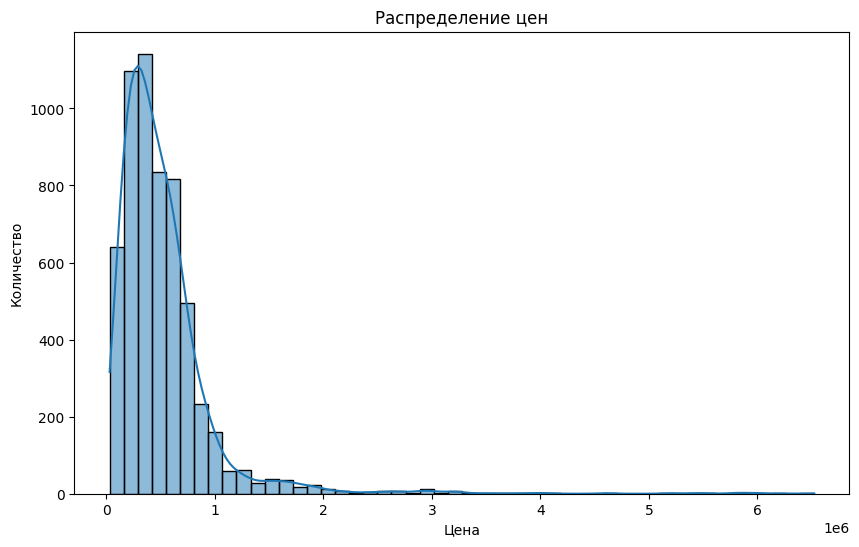

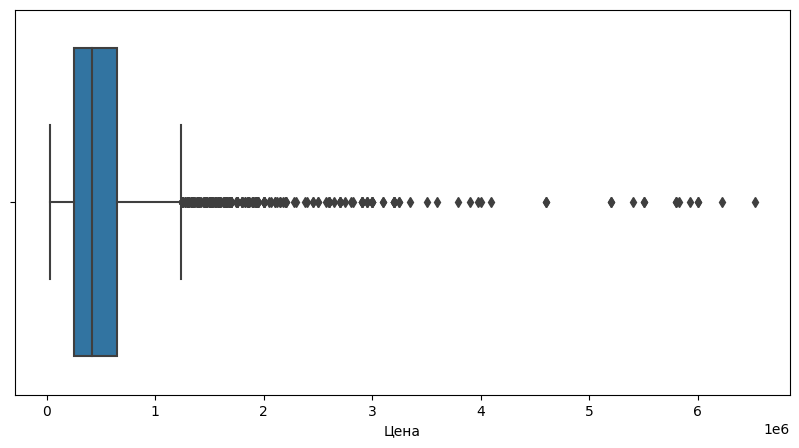

In [74]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df['selling_price'], kde=True, bins=50)
plt.title('Распределение цен')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()


plt.figure(figsize=(10, 5))
sns.boxplot(x=df['selling_price'])
plt.xlabel('Цена')
plt.show()

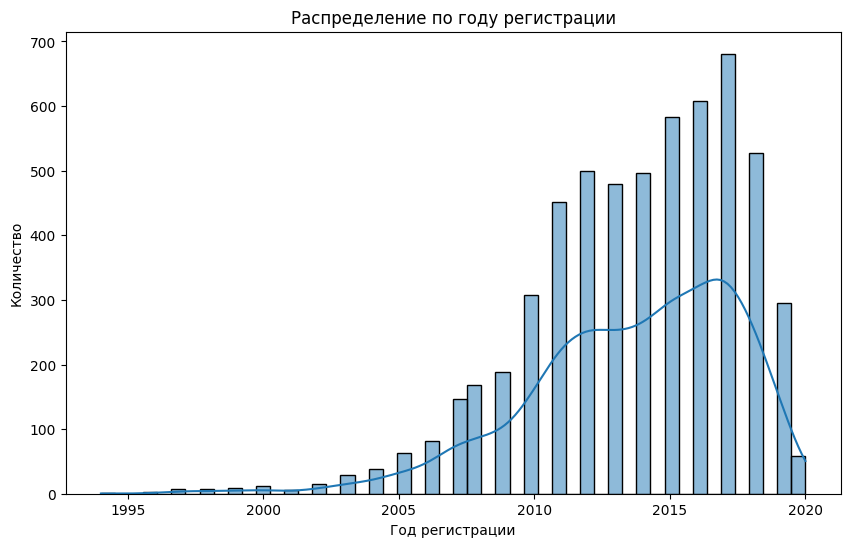

In [75]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df['year'], kde=True, bins=50)
plt.title('Распределение по году регистрации')
plt.xlabel('Год регистрации')
plt.ylabel('Количество')
plt.show()

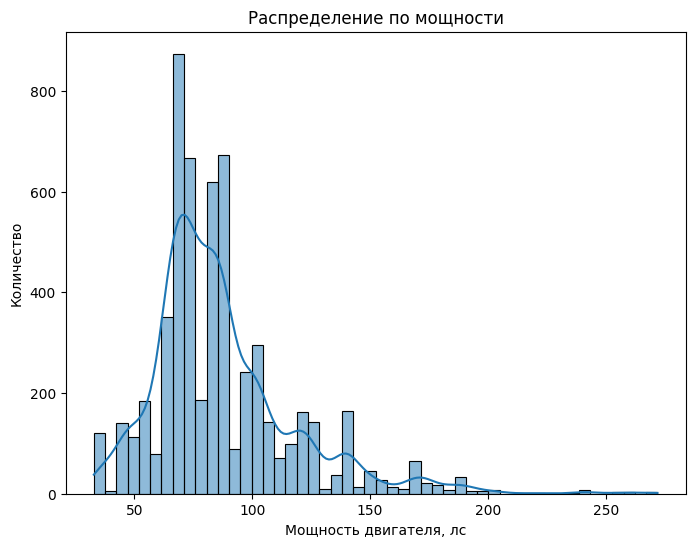

In [76]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df['max_power'], kde=True, bins=50)
plt.title('Распределение по мощности')
plt.xlabel('Мощность двигателя, лс')
plt.ylabel('Количество')
plt.show()

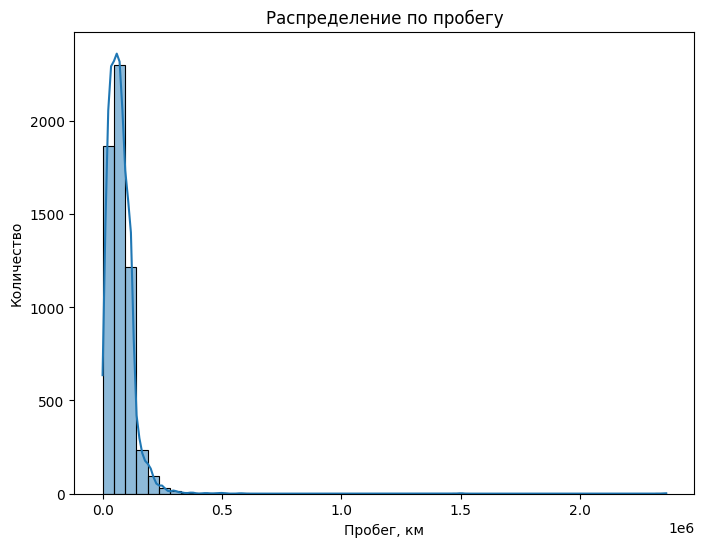

In [77]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df['km_driven'], kde=True, bins=50)
plt.title('Распределение по пробегу')
plt.xlabel('Пробег, км')
plt.ylabel('Количество')
plt.show()

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
carsdata = df.to_csv('/content/drive/MyDrive/Colab Notebooks/cleaned_carsdata.csv')

In [80]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

In [81]:
features_test = df_test.drop(['selling_price'], axis=1)
target_test = df_test['selling_price']

features_train = df_train.drop(['selling_price'], axis=1)
target_train = df_train['selling_price']

In [82]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4612 entries, 72 to 4578
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            4612 non-null   int64  
 1   km_driven       4612 non-null   int64  
 2   fuel            4612 non-null   object 
 3   seller_type     4612 non-null   object 
 4   transmission    4612 non-null   object 
 5   owner           4612 non-null   object 
 6   mileage         4612 non-null   float64
 7   engine          4612 non-null   float64
 8   max_power       4612 non-null   float64
 9   seats           4612 non-null   int64  
 10  brand           4612 non-null   object 
 11  torque_nm       4612 non-null   float64
 12  torque_max_rpm  4612 non-null   int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 504.4+ KB


In [83]:
features_train.head()

,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,brand,torque_nm,torque_max_rpm
72,2016,49000,petrol,dealer,manual,first owner,19.02,1198.0,67.05,5,datsun go,104.0,4000
2111,2016,90000,petrol,individual,manual,first owner,25.17,799.0,53.30,5,renault kwid,72.0,4386
4692,2008,80000,petrol,individual,manual,third owner,19.70,796.0,46.30,5,maruti alto,62.0,3000
5307,2007,100000,diesel,individual,manual,second owner,16.60,1896.0,122.40,5,skoda octavia,214.0,1900
2961,2014,40000,petrol,individual,manual,second owner,18.90,1197.0,82.00,5,hyundai grand,114.0,4000


In [84]:
#categorial_RF = ['fuel', 'seller_type', 'transmission', 'owner', 'brand', 'model', 'variant']

In [85]:
categorial_RF = features_train.select_dtypes(include='object').columns.to_list()
print(categorial_RF)

['fuel', 'seller_type', 'transmission', 'owner', 'brand']


In [86]:
#numeric = ['year',
# 'km_driven',
# 'mileage',
#'engine',
#'max_power',
#'torque_nm',
#'torque_max_rpm',
#          'seats']

In [87]:
numeric = features_train.select_dtypes(exclude='object').columns.to_list()
numeric

['year',
 'km_driven',
 'mileage',
 'engine',
 'max_power',
 'seats',
 'torque_nm',
 'torque_max_rpm']

In [88]:
scaler = StandardScaler()
scaler.fit(df_train[numeric])
features_train[numeric] = scaler.transform(df_train[numeric])
features_test[numeric] = scaler.transform(df_test[numeric])

pd.options.mode.chained_assignment = None
features_train.head()

,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,brand,torque_nm,torque_max_rpm
72,0.618552,-0.394449,petrol,dealer,manual,first owner,-0.146902,-0.467182,-0.657791,-0.445354,datsun go,-0.658225,1.030785
2111,0.618552,0.255774,petrol,individual,manual,first owner,1.268457,-1.289872,-1.109212,-0.445354,renault kwid,-0.960914,1.446453
4692,-1.457316,0.097183,petrol,individual,manual,third owner,0.009593,-1.296058,-1.339026,-0.445354,maruti alto,-1.055504,-0.046078
5307,-1.716800,0.414365,diesel,individual,manual,second owner,-0.703841,0.972010,1.159382,-0.445354,skoda octavia,0.382268,-1.230626
2961,0.099585,-0.537181,petrol,individual,manual,second owner,-0.174519,-0.469244,-0.166974,-0.445354,hyundai grand,-0.563635,1.030785


In [89]:
encoder_ohe = OneHotEncoder(drop="first", handle_unknown="ignore")
encoder_ohe.fit(features_train[categorial_RF])

tmp_train = pd.DataFrame(encoder_ohe.transform(features_train[categorial_RF]).toarray(),
                                   columns=encoder_ohe.get_feature_names_out(),
                                   index=features_train.index)

In [90]:
tmp_test = pd.DataFrame(encoder_ohe.transform(features_test[categorial_RF]).toarray(),
                                   columns=encoder_ohe.get_feature_names_out(),
                                   index=features_test.index)

In [91]:
features_train.drop(categorial_RF, axis=1, inplace=True)
features_train = features_train.join(tmp_train)

features_test.drop(categorial_RF, axis=1, inplace=True)
features_test = features_test.join(tmp_test)

In [92]:
features_train.shape

(4612, 170)

Линейная регрессия

In [93]:
model_lr = LinearRegression()
curr_time = time.time()
model_lr.fit(features_train, target_train)
fit_time_linear = round((time.time() - curr_time), 3)
curr_time = time.time()
predicted_test = model_lr.predict(features_test)

predict_time_linear = round((time.time() - curr_time), 3)
rmse_linear = round(mean_squared_error(target_test, predicted_test)**0.5, 3)

print('RMSE:', rmse_linear)
print('Время обучения:', fit_time_linear)
print('Время предсказания:', predict_time_linear)

RMSE: 173483.435
Время обучения: 0.205
Время предсказания: 0.012


LightGBM

In [94]:
model_lgbm = LGBMRegressor()
params_lgbm = {'learning_rate': np.arange(0.03, 0.1),
               'n_estimators': range(150, 4500, 150),
               'num_leaves': range(50, 500, 50),
               'max_depth': range(1, 51, 5)}

grid_lgbm = RandomizedSearchCV(
    model_lgbm,
    params_lgbm,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_lgbm.fit(features_train, target_train)
display(f'best_score: {grid_lgbm.best_score_ * -1}')
display(f'best_params: {grid_lgbm.best_params_}')


'best_score: 127382.82307762533'

"best_params: {'num_leaves': 300, 'n_estimators': 4050, 'max_depth': 6, 'learning_rate': 0.03}"

In [106]:
model = LGBMRegressor(
    boosting_type='gbdt',
    random_state=RANDOM_STATE,
    max_depth=6,
    n_estimators=4050,
    learning_rate = 0.03,
    num_leaves = 300)
curr_time = time.time()
model.fit(features_train, target_train)
fit_time_lgbm = round((time.time() - curr_time), 3)
curr_time = time.time()
predicted_test = model.predict(features_test)
predict_time_lgbm = round((time.time() - curr_time), 3)
rmse_lgbm = round(mean_squared_error(target_test, predicted_test)**0.5, 3)

print('RMSE:', rmse_lgbm)
print('Время обучения:', fit_time_lgbm)
print('Время предсказания:', predict_time_lgbm)

RMSE: 151669.142
Время обучения: 9.651
Время предсказания: 0.558


Дерево решений

In [96]:
model_dtr = DecisionTreeRegressor()
params_dtr = {'min_samples_leaf': range(2, 50, 2),
               'min_samples_split': range(2, 50, 2),
               'max_depth': range(1, 51, 5)}

grid_dtr = RandomizedSearchCV(
    model_dtr,
    params_dtr,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_dtr.fit(features_train, target_train)
display(f'best_score: {grid_dtr.best_score_ * -1}')
display(f'best_params: {grid_dtr.best_params_}')

'best_score: 170739.95181470126'

"best_params: {'min_samples_split': 14, 'min_samples_leaf': 10, 'max_depth': 46}"

In [107]:
model = DecisionTreeRegressor(max_depth=46, random_state=RANDOM_STATE, min_samples_leaf=10, min_samples_split=14)
curr_time = time.time()
model.fit(features_train, target_train)
fit_time_dt = round((time.time() - curr_time), 3)
curr_time = time.time()
predicted_test = model.predict(features_test)
predict_time_dt = round((time.time() - curr_time), 3)
rmse_dt = round(mean_squared_error(target_test, predicted_test)**0.5, 3)

print('RMSE:', rmse_dt)
print('Время обучения:', fit_time_dt)
print('Время предсказания:', predict_time_dt)

RMSE: 215152.616
Время обучения: 0.085
Время предсказания: 0.006


Модель случайного леса

In [98]:
model_rf = RandomForestRegressor()
params_rf = {'n_estimators': range(10, 510, 10),
             'min_samples_leaf': range(2, 50, 2),
             'min_samples_split': range(2, 50, 2),
             'max_depth': range(1, 101, 5)}

grid_rf = RandomizedSearchCV(
    model_rf,
    params_rf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_rf.fit(features_train, target_train)
display(f'best_score: {grid_rf.best_score_ * -1}')
display(f'best_params: {grid_rf.best_params_}')

'best_score: 184294.6095138275'

"best_params: {'n_estimators': 190, 'min_samples_split': 12, 'min_samples_leaf': 14, 'max_depth': 71}"

In [108]:
model = RandomForestRegressor(n_estimators=190, max_depth=71, random_state=RANDOM_STATE, min_samples_leaf=14, min_samples_split=12)
curr_time = time.time()
model.fit(features_train, target_train)
fit_time_rf = round((time.time() - curr_time), 3)
curr_time = time.time()
predicted_test = model.predict(features_test)
predict_time_rf = round((time.time() - curr_time), 3)
rmse_rf = round(mean_squared_error(target_test, predicted_test)**0.5, 3)

print('RMSE:', rmse_rf)
print('Время обучения:', fit_time_rf)
print('Время предсказания:', predict_time_rf)

RMSE: 209613.351
Время обучения: 7.027
Время предсказания: 0.048


CatBoost

In [100]:
model_cb = CatBoostRegressor()
params_cb = {'n_estimators': range(25, 2500, 75),
             'learning_rate': np.arange(0.01, 1),
             'random_seed': range(5, 150, 5),
             'verbose': range(5, 150, 5),
             'depth': range(1, 16, 5)}

grid_cb = RandomizedSearchCV(
    model_cb,
    params_cb,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1, error_score='raise'
)

grid_cb.fit(features_train, target_train)
display(f'best_score: {grid_cb.best_score_ * -1}')
display(f'best_params: {grid_cb.best_params_}')

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0:	learn: 463840.9207735	total: 90.7ms	remaining: 3m 39s
25:	learn: 393575.0471539	total: 955ms	remaining: 1m 28s
50:	learn: 336833.4667066	total: 1.82s	remaining: 1m 24s
75:	learn: 291798.5758469	total: 2.71s	remaining: 1m 23s
100:	learn: 254750.3186716	total: 3.57s	remaining: 1m 22s
125:	learn: 225077.5562792	total: 4.44s	remaining: 1m 20s
150:	learn: 201194.4647163	total: 5.27s	remaining: 1m 19s
175:	learn: 181600.0943977	total: 6.16s	remaining: 1m 18s
200:	learn: 166055.4184312	total: 7.03s	remaining: 1m 17s
225:	learn: 153737.6060070	total: 7.9s	remaining: 1m 16s
250:	learn: 143493.4290184	total: 9.05s	remaining: 1m 18s
275:	learn: 135351.5989518	total: 10.7s	remaining: 1m 23s
300:	learn: 128537.0120819	total: 12.3s	remaining: 1m 27s
325:	learn: 122986.3446345	total: 14s	remaining: 1m 29s
350:	learn: 118652.2982879	total: 15.5s	remaining: 1m 31s
375:	learn: 115096.0847777	total: 16.3s	remaining: 1m 29s
400:	learn: 112044.8088389	total: 17.2s	remaining: 1m 26s
425:	learn: 109345.26

'best_score: 116433.01091038375'

"best_params: {'verbose': 25, 'random_seed': 105, 'n_estimators': 2425, 'learning_rate': 0.01, 'depth': 11}"

In [109]:
model_cb = CatBoostRegressor(depth=6, n_estimators=2425, random_seed=105, learning_rate=0.01, verbose=25)
model_cb.fit(features_train, target_train)
fit_time_cb = round((time.time() - curr_time), 3)
curr_time = time.time()
predicted_test = model_cb.predict(features_test)
predict_time_cb = round((time.time() - curr_time), 3)
rmse_cb = round(mean_squared_error(target_test, predicted_test)**0.5, 3)

print('RMSE:', rmse_cb)
print('Время обучения:', fit_time_cb)
print('Время предсказания:', predict_time_cb)

0:	learn: 463683.6154300	total: 11.5ms	remaining: 27.9s
25:	learn: 393346.1635573	total: 122ms	remaining: 11.3s
50:	learn: 338422.6609507	total: 288ms	remaining: 13.4s
75:	learn: 294260.0446258	total: 361ms	remaining: 11.1s
100:	learn: 259513.3363276	total: 493ms	remaining: 11.3s
125:	learn: 232254.8151201	total: 668ms	remaining: 12.2s
150:	learn: 211134.2316517	total: 854ms	remaining: 12.9s
175:	learn: 194188.5091430	total: 1.04s	remaining: 13.3s
200:	learn: 180534.0622368	total: 1.22s	remaining: 13.5s
225:	learn: 170465.7381486	total: 1.37s	remaining: 13.3s
250:	learn: 162438.4252568	total: 1.58s	remaining: 13.7s
275:	learn: 155585.2060185	total: 1.75s	remaining: 13.7s
300:	learn: 150366.7069664	total: 1.99s	remaining: 14s
325:	learn: 146265.7685503	total: 2.17s	remaining: 14s
350:	learn: 142498.4166655	total: 2.33s	remaining: 13.7s
375:	learn: 139132.8293472	total: 2.43s	remaining: 13.2s
400:	learn: 136308.6553258	total: 2.56s	remaining: 12.9s
425:	learn: 133664.1714650	total: 2.69s

Анализ моделей

In [110]:
results = pd.DataFrame([
    [rmse_linear, fit_time_linear, predict_time_linear],
    [rmse_lgbm, fit_time_lgbm, predict_time_lgbm],
    [rmse_dt, fit_time_dt, predict_time_dt],
    [rmse_rf, fit_time_rf, predict_time_rf],
    [rmse_cb, fit_time_cb, predict_time_cb]],
    columns=['RMSE', 'Время обучения', 'Время предсказания'],
    index=['LinearRegression','LightGBM', 'DecisionTree', 'RandomForest', 'CatBoost'])


In [111]:
results.sort_values(by='RMSE')

,RMSE,Время обучения,Время предсказания
CatBoost,140472.678,39.839,0.032
LightGBM,151669.142,9.651,0.558
LinearRegression,173483.435,0.205,0.012
RandomForest,209613.351,7.027,0.048
DecisionTree,215152.616,0.085,0.006


In [118]:
import pickle

In [119]:
filename = 'finalized_model.mw'
pickle.dump(model_cb, open(filename, 'wb'))